In [89]:
import csv

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42

# Specify each path

In [90]:
dataset = 'model/keypoint_classifier/keypoint.csv'
model_save_path = 'model/keypoint_classifier/keypoint_classifier.hdf5'
tflite_save_path = 'model/keypoint_classifier/keypoint_classifier.tflite'

# Set number of classes

In [91]:
NUM_CLASSES = 6

# Dataset reading

In [92]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1)))

In [93]:
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

In [94]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

# Model building

In [95]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((21 * 2, )),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

In [96]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout_12 (Dropout)        (None, 42)                0         
                                                                 
 dense_18 (Dense)            (None, 20)                860       
                                                                 
 dropout_13 (Dropout)        (None, 20)                0         
                                                                 
 dense_19 (Dense)            (None, 10)                210       
                                                                 
 dense_20 (Dense)            (None, 6)                 66        
                                                                 
Total params: 1136 (4.44 KB)
Trainable params: 1136 (4.44 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [97]:
# Model checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
# Callback for early stopping
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

In [98]:
# Model compilation
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Model training

In [99]:
model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/1000
70/74 [===========================>..] - ETA: 0s - loss: 1.6950 - accuracy: 0.2838
Epoch 1: saving model to model/keypoint_classifier/keypoint_classifier.hdf5
74/74 [==============================] - 2s 8ms/step - loss: 1.6915 - accuracy: 0.2859 - val_loss: 1.5311 - val_accuracy: 0.4272
Epoch 2/1000
55/74 [=====================>........] - ETA: 0s - loss: 1.5014 - accuracy: 0.3645

/Users/yoon/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 2: saving model to model/keypoint_classifier/keypoint_classifier.hdf5
74/74 [==============================] - 0s 3ms/step - loss: 1.4793 - accuracy: 0.3821 - val_loss: 1.2932 - val_accuracy: 0.5891
Epoch 3/1000
56/74 [=====================>........] - ETA: 0s - loss: 1.3044 - accuracy: 0.5043
Epoch 3: saving model to model/keypoint_classifier/keypoint_classifier.hdf5
74/74 [==============================] - 0s 3ms/step - loss: 1.2806 - accuracy: 0.5134 - val_loss: 1.0734 - val_accuracy: 0.6185
Epoch 4/1000
58/74 [======================>.......] - ETA: 0s - loss: 1.1305 - accuracy: 0.5540
Epoch 4: saving model to model/keypoint_classifier/keypoint_classifier.hdf5
74/74 [==============================] - 0s 3ms/step - loss: 1.1164 - accuracy: 0.5617 - val_loss: 0.9212 - val_accuracy: 0.6732
Epoch 5/1000
59/74 [======================>.......] - ETA: 0s - loss: 1.0527 - accuracy: 0.5793
Epoch 5: saving model to model/keypoint_classifier/keypoint_classifier.hdf5
74/74 [=============

In [100]:
# Model evaluation
val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=128)

25/25 [==============================] - 0s 2ms/step - loss: 0.2490 - accuracy: 0.9511


In [101]:
# Loading the saved model
model = tf.keras.models.load_model(model_save_path)

In [102]:
# Inference test
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

1/1 [==============================] - 0s 86ms/step
[5.5807902e-07 3.3508475e-06 8.4352760e-06 7.7465020e-02 5.6069648e-08
 9.2252260e-01]
5


# Confusion matrix

98/98 [==============================] - 0s 1ms/step


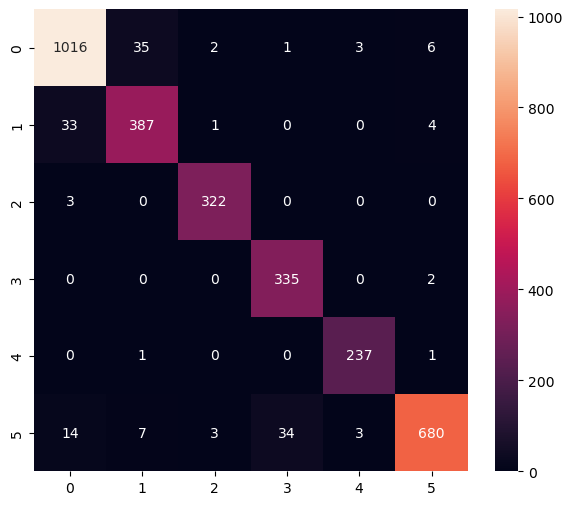

Classification Report
              precision    recall  f1-score   support

           0       0.95      0.96      0.95      1063
           1       0.90      0.91      0.91       425
           2       0.98      0.99      0.99       325
           3       0.91      0.99      0.95       337
           4       0.98      0.99      0.98       239
           5       0.98      0.92      0.95       741

    accuracy                           0.95      3130
   macro avg       0.95      0.96      0.95      3130
weighted avg       0.95      0.95      0.95      3130



In [103]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

# Convert to model for Tensorflow-Lite

In [104]:
# Save as a model dedicated to inference
model.save(model_save_path, include_optimizer=False)

/Users/yoon/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [105]:
# Transform model (quantization)

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: /var/folders/m1/nzwkx_t91v1c1lzszjqmggc80000gn/T/tmpcyldq11a/assets


INFO:tensorflow:Assets written to: /var/folders/m1/nzwkx_t91v1c1lzszjqmggc80000gn/T/tmpcyldq11a/assets
2023-12-29 23:09:32.941600: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2023-12-29 23:09:32.941622: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2023-12-29 23:09:32.941895: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /var/folders/m1/nzwkx_t91v1c1lzszjqmggc80000gn/T/tmpcyldq11a
2023-12-29 23:09:32.943764: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2023-12-29 23:09:32.943779: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /var/folders/m1/nzwkx_t91v1c1lzszjqmggc80000gn/T/tmpcyldq11a
2023-12-29 23:09:32.948932: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2023-12-29 23:09:33.017469: I tensorflow/cc/saved_model/loader.cc:217] Running initialization

6696

# Inference test

In [106]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

In [107]:
# Get I / O tensor
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [108]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

In [109]:
%%time
# Inference implementation
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

CPU times: user 47 µs, sys: 16 µs, total: 63 µs
Wall time: 61 µs


In [110]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[5.5807959e-07 3.3508447e-06 8.4352778e-06 7.7464983e-02 5.6069545e-08
 9.2252272e-01]
5
